## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [3]:
import zipfile
path = Path('data')

# # RUN ONCE - Unzip the data
# myfile1 = 'ISIC-2017_Validation_Data.zip'
# myfile2 = 'ISIC-2017_Validation_Part1_GroundTruth.zip'
# with zipfile.ZipFile(path/myfile1,"r") as zip_ref:
#     zip_ref.extractall(path/'MelanomaX')
# with zipfile.ZipFile(path/myfile2,"r") as zip_ref:
#     zip_ref.extractall(path/'MelanomaY')


In [4]:
path_lbl = path/'MelanomaY'/'ISIC-2017_Validation_Part1_GroundTruth'
path_img = path/'MelanomaX'/'ISIC-2017_Validation_Data'

In [5]:
# RUN ONCE - Remove "superpixels" files
# fnames = os.listdir(path_img)
# for name in fnames:
#     if "superpixels" in name:
#         os.remove(path_img/name)

## Data

In [6]:
fnames = get_image_files(path_img)

In [7]:
lbl_names = get_image_files(path_lbl)

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_segmentation.png'

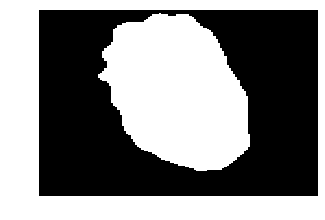

In [9]:
img = get_y_fn(fnames[0])
img = open_image(img)
img.show(figsize=(5,5))

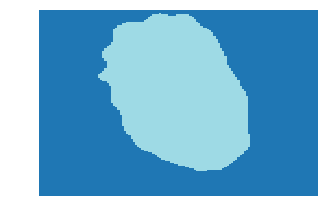

In [10]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([2848, 4288]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
np.unique(mask.data)

array([  0, 255])

In [13]:
label_classes = np.array(['Skin', 'Condition'])
label_classes

array(['Skin', 'Condition'], dtype='<U9')

## Datasets

In [14]:
size = src_size//8
bs = 4

In [15]:
# These classes are needed to because our masks are either 0 or 255 (and fastai doesn't like that)
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(path_img)
          .split_by_rand_pct(0.2)
          .label_from_func(get_y_fn, classes=label_classes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

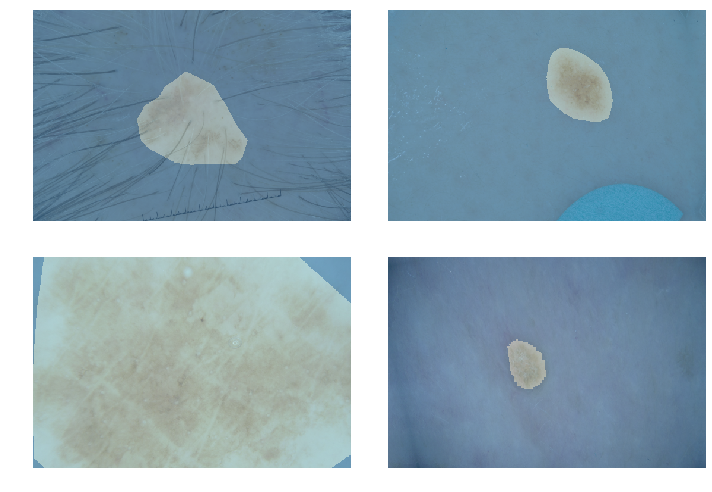

In [17]:
data.show_batch(2, figsize=(10,7))

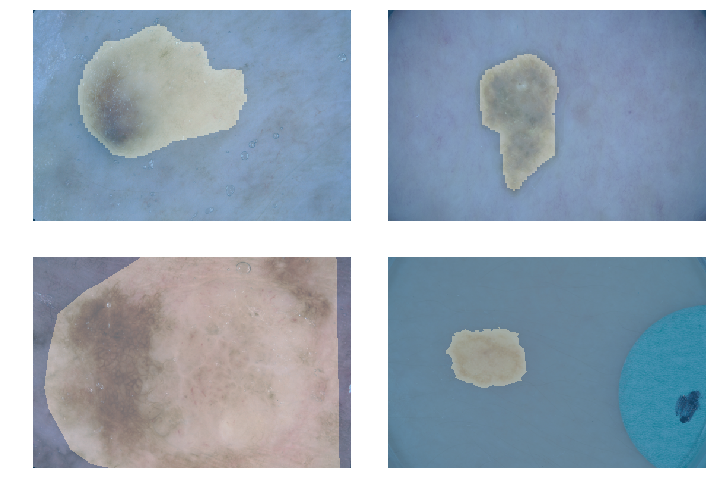

In [18]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
# Modified accuracy metric for the problem
# Modified with a notebook I found online
def acc_melan(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [20]:
metrics=acc_melan
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
# lr_find(learn)
# learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_melan,time
0,0.439407,0.293124,0.885798,01:01
1,0.407771,0.275954,0.895984,00:48
2,0.396437,0.254145,0.891817,00:46
3,0.387777,0.313756,0.891929,00:46
4,0.417458,0.299960,0.887668,00:46
5,0.520108,0.312891,0.887366,00:47
6,0.502419,0.479705,0.851430,00:47
7,1.249742,0.669075,0.857294,00:46
8,1.348171,0.673469,0.665125,00:44
9,1.071743,0.324017,0.887443,00:46


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

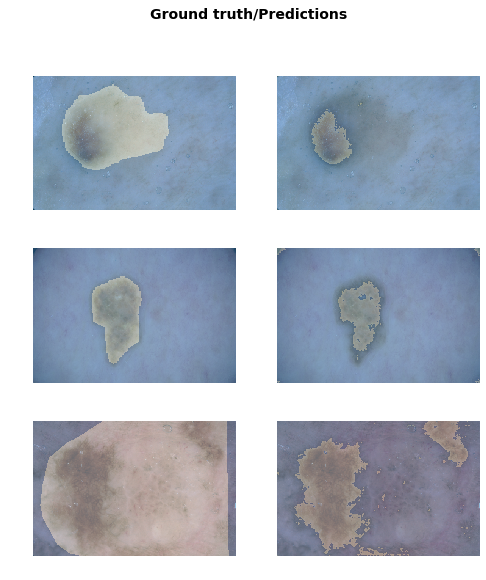

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_melan,time
0,0.406672,0.307516,0.891616,00:47
1,0.385535,0.281291,0.894481,00:45
2,0.367515,0.259221,0.900394,00:47
3,0.320573,0.261630,0.894354,00:46
4,0.329762,0.370465,0.854770,00:46
5,0.319996,0.346409,0.902930,00:48
6,0.286740,0.211309,0.909750,00:48
7,0.295683,0.222059,0.917686,00:47
8,0.257274,0.230576,0.912925,00:46
9,0.223306,0.328235,0.877338,00:47


In [32]:
learn.save('stage-2');

In [33]:
learn.load('stage-2');

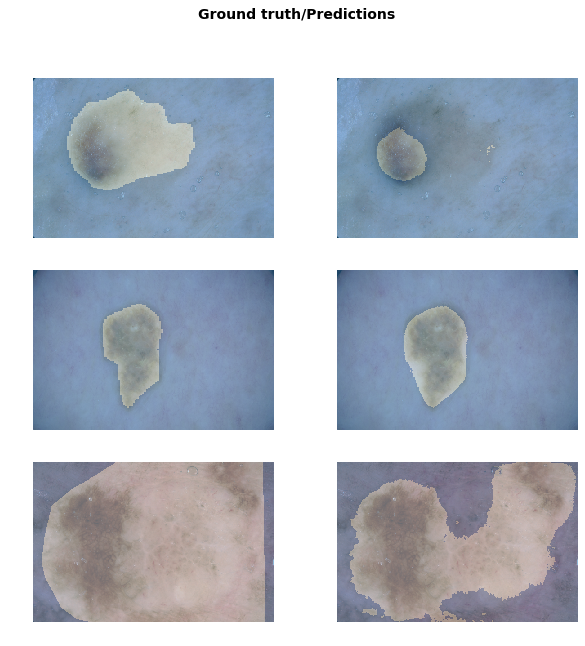

In [34]:
learn.show_results(rows=3, figsize=(10,10))

## Give the model something it has never seen

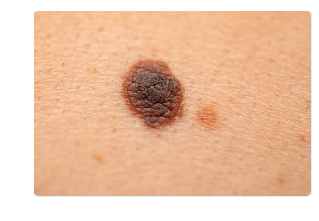

In [36]:
img = open_image(path/'never-seen.jpg')
img.show(figsize=(5,5))

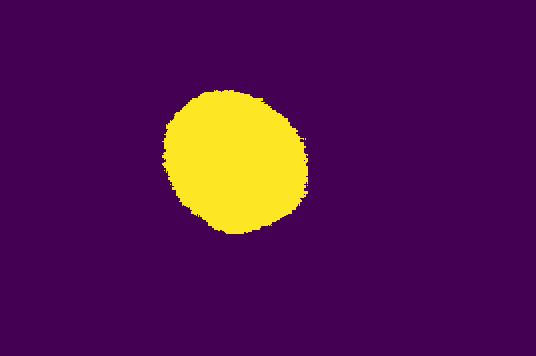

In [37]:
prediction = learn.predict(img)[0]
prediction